# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом  разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. На основе исторические данные необходимо построить модель для определения стоимости автомобиля.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

На входе были полученны данные о продажах автомобилей:  

**Признаки:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  

**Целевой признак**
- Price - цена (евро)

**Алгоритм исследования:**
1) Провести предобработку и исследовательский аналих данных, избавиться от пропусков и аномалий.  
2) Провести подготовку данных для обучения моделей, разбить на выборки, провести кодирование категориальных признаков и масштабирование численных  
3) Обучить на подготовленных данных различные регрессионные модели:  
    - Градиентный бустинг (LightGBM и CatBoost)  
    - Линейная регрессия  
    - Случайный лес  
4) Проанализировать различные показатели моделей (метрики качества, время обучения и предсказания, удобство использования и т.д.)  
5) Вывод  

## Подготовка данных

In [1]:
import warnings
#Импорты сторонних библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Импорты модулей
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
#Импорты фреймворков градиентного бустинга
import lightgbm as lgb
from catboost import (
    CatBoostRegressor,
    Pool,
    cv)

warnings.filterwarnings('ignore')

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')
objects_originally = data.shape[0]

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Сократим количество признаков ввиду того, что они не могу влиять на цену автомобиля, а следовательно являются избыточными для целей нашего исследования:  
- дата скачивания анкеты из базы
- дата создания объявления
- количество фотографий
- почтовый индекс пользователя
- дата последней активности пользователя
- месяц регистрации ТС

In [4]:
#Удаляем неинформативные столбцы, не оказывающие влияния на целевой признак
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [6]:
data.describe(include='all')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
count,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,321474,354369,283215
unique,NaN,8,NaN,2,NaN,250,NaN,7,40,2
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no
freq,NaN,91457,NaN,268251,NaN,29232,NaN,216352,77013,247161
mean,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,NaN,NaN,NaN
std,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,NaN,NaN,NaN
25%,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,NaN,NaN,NaN
50%,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,NaN,NaN,NaN
75%,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,NaN,NaN,NaN


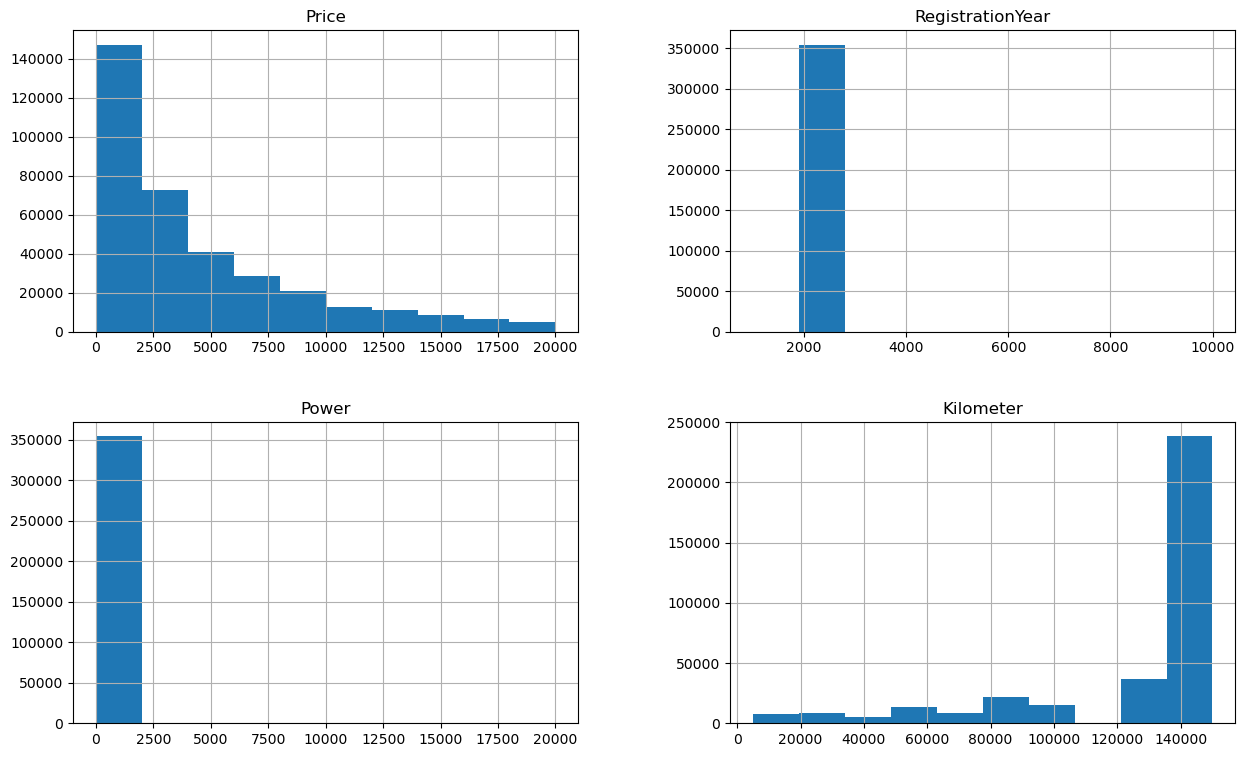

In [7]:
data.hist(figsize=(15,9));

По гистограммам понятно, что в данных присутствуют аномальные значения.  
- Удалить нулевые значения во всех признаках
- Ограничить минимальную цену в 50-100 евро.
- Ограничить года выпуска между 1950 и 2022
- Ограничить мощность двигателя 501 л.с.

In [8]:
#Смотрим пропуски
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'percent'})
            .query('percent > 0')
            .sort_values(by = 'percent', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = 0, legend = False, fontsize = 16)
            .set_title('Процент пропусков' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

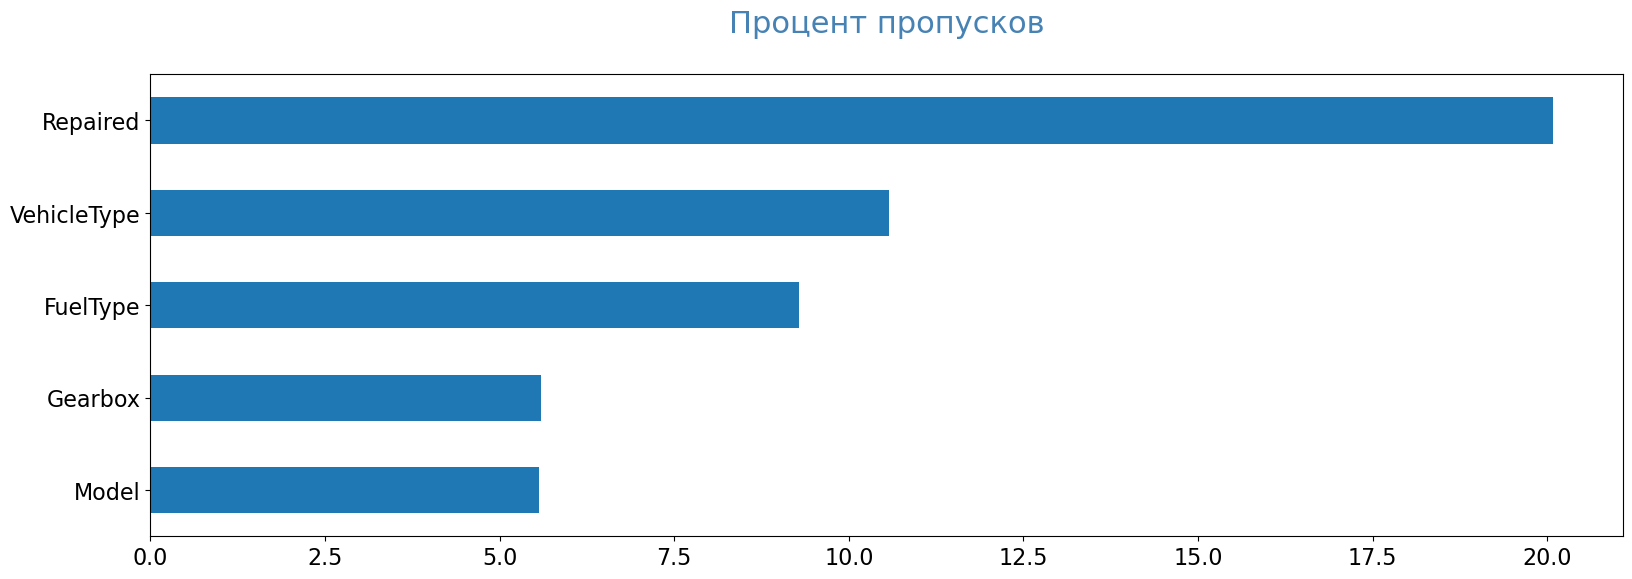

In [9]:
pass_value_barh(data)

In [10]:
#Удаляем строки с пропусками в колонке Модель, заполнить адекватно не представляется возможным, а модель машины - один из 
#наиболее влиятельных признаков
data.dropna(subset=['Model'], inplace=True)
#data['Model'] = data['Model'].fillna('unknown')

In [11]:
##Пропуски в типах кузова ТС заполним значениями соответсвующим совпадениям Марка машины + Модель
#data['Brand+Model'] = data['Brand'] + '_' + data['Model']
#data_for_vehicle_type = data[['Brand+Model', 'VehicleType']].dropna()
#get_max = lambda x: x.value_counts(dropna=False).index[0]
#data_for_vehicle_type = data_for_vehicle_type.groupby(['Brand+Model'])['VehicleType'].agg(get_max)
#data = data.set_index('Brand+Model')
#data['VehicleType'] = data['VehicleType'].fillna(data_for_vehicle_type)
#drops_vehicle_type = data['VehicleType'].isna().sum()
#print(f'Осталось пропусков:{drops_vehicle_type}')

In [12]:
# Код ревьюера
get_max = lambda x: x.value_counts(dropna=False).index[0]
data_for_vehicle_type = data.dropna(subset=['Brand', 'Model', 'VehicleType'])
data_for_vehicle_type = data_for_vehicle_type.groupby(['Brand','Model'])['VehicleType'].agg(get_max)
data = data.set_index(['Brand','Model'])
data['VehicleType'] = data['VehicleType'].fillna(data_for_vehicle_type)
drops_vehicle_type = data['VehicleType'].isna().sum()
print(f'Осталось пропусков:{drops_vehicle_type}')

Осталось пропусков:0


In [13]:
##Заполняем пропуски и аномалии следующим образом:
## - Для начала отсекаем слишком маленькие или большие значения
## - Заполняем пропуски соответствеющими значениями про совпадении Марки и Модели ТС (самым частым)
## - Оставшиеся пропуски заполняем медианным значением по типу кузова ТС
#data_for_power = data['Power']
#data_for_power = data_for_power.loc[lambda x: (x < 501) & (x > 30)]
#data_for_power = data_for_power.reset_index().groupby('Brand+Model')['Power'].agg(get_max)
#data.loc[data['Power'] < 30, 'Power'] = np.nan
#data.loc[data['Power'] > 501, 'Power'] = np.nan
#data['Power'] = data['Power'].fillna(data_for_power)
#data['Power'] = data['Power'].fillna(data.groupby('VehicleType')['Power'].transform('median'))
#drops_power = data['Power'].isna().sum()
#print(f'Осталось пропусков:{drops_power}')

In [14]:
# Код ревьюера
data.loc[(data['Power'] < 30)&(data['Power'] > 501),'Power'] = np.nan
data_for_power = data['Power'].dropna()
data_for_power = data_for_power.reset_index().groupby(['Brand','Model'])['Power'].agg(get_max)
data['Power'] = data['Power'].fillna(data_for_power)
data['Power'] = data['Power'].fillna(data.groupby('VehicleType')['Power'].transform('median'))
drops_power = data['Power'].isna().sum()
print(f'Осталось пропусков:{drops_power}')

Осталось пропусков:0


In [15]:
#Отсекаем совсем нереальные значения годов выпуска, заполнять бессмысленно, год оказывает сильное влияние на целевой признак.
#data.query('RegistrationYear < 1950' or 'RegistrationYear > 2022')['RegistrationYear'].value_counts()
data = data.query('1950 < RegistrationYear < 2017')

In [16]:
#Отсутсвующие значения типа коробки передач в зависимости от года выпуска
data.loc[data['Gearbox'].isna()].sort_values(by='RegistrationYear', ascending=True)['RegistrationYear'].value_counts()

2000    2106
2005    1469
2016    1095
1995     825
1999     694
        ... 
1952       2
1955       1
1957       1
1958       1
1951       1
Name: RegistrationYear, Length: 66, dtype: int64

In [17]:
#Оптимально заполнить пропуски самой распостраненной коробкой.
data['Gearbox'] = data['Gearbox'].fillna('manual')

In [18]:
data['Kilometer'].value_counts()

150000    215804
125000     33726
100000     13651
90000      10819
80000       9421
70000       8045
60000       7037
50000       5823
40000       4624
5000        4522
30000       4094
20000       3486
10000        994
Name: Kilometer, dtype: int64

In [19]:
data['FuelType'].value_counts()

petrol      201469
gasoline     93680
lpg           4828
cng            522
hybrid         200
other          128
electric        65
Name: FuelType, dtype: int64

In [20]:
#Заполняем пропуски самым популярным видом топлива
data['FuelType'] = data['FuelType'].fillna('petrol')

In [21]:
#Заполняем пропуски значением "нет", что наиболее вероятно, столбец делаем бинарным.
data['Repaired'] = data['Repaired'].fillna('no')
data['Repaired'] = np.where(data['Repaired'] == 'no', 0, 1)
data['Repaired'] = data['Repaired'].astype('int64')

пропусков не осталось :) 


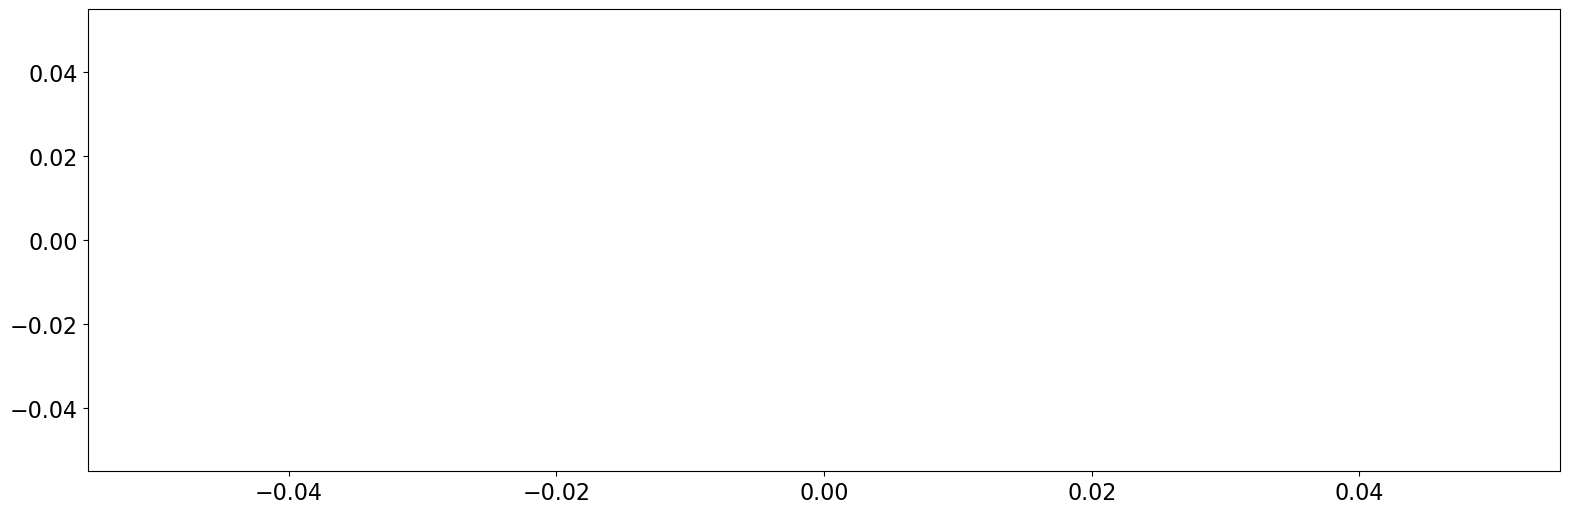

In [22]:
pass_value_barh(data)

In [23]:
data['Power'] = data['Power'].astype('int64')

In [24]:
data = data.query('Price > 50').reset_index()

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312556 entries, 0 to 312555
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Brand             312556 non-null  object
 1   Model             312556 non-null  object
 2   Price             312556 non-null  int64 
 3   VehicleType       312556 non-null  object
 4   RegistrationYear  312556 non-null  int64 
 5   Gearbox           312556 non-null  object
 6   Power             312556 non-null  int64 
 7   Kilometer         312556 non-null  int64 
 8   FuelType          312556 non-null  object
 9   Repaired          312556 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 23.8+ MB


In [26]:
data.describe(include='all')

,Brand,Model,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,Repaired
count,312556,312556,312556.000000,312556,312556.000000,312556,312556.000000,312556.000000,312556,312556.000000
unique,39,250,NaN,8,NaN,2,NaN,NaN,7,NaN
top,volkswagen,golf,NaN,sedan,NaN,manual,NaN,NaN,petrol,NaN
freq,67741,26613,NaN,92613,NaN,252482,NaN,NaN,214736,NaN
mean,NaN,NaN,4693.654366,NaN,2002.773743,NaN,113.081995,128523.960506,NaN,0.098110
std,NaN,NaN,4557.936742,NaN,6.512597,NaN,179.741334,36869.395316,NaN,0.297464
min,NaN,NaN,55.000000,NaN,1951.000000,NaN,0.000000,5000.000000,NaN,0.000000
25%,NaN,NaN,1250.000000,NaN,1999.000000,NaN,75.000000,125000.000000,NaN,0.000000
50%,NaN,NaN,2999.000000,NaN,2003.000000,NaN,105.000000,150000.000000,NaN,0.000000
75%,NaN,NaN,6800.000000,NaN,2007.000000,NaN,143.000000,150000.000000,NaN,0.000000


In [27]:
objects_finally = data.shape[0]
drop_loss = (objects_originally - objects_finally) / objects_originally * 100
print(f'Относительно оригинального датасета, количество объектвом уменьшилось на {drop_loss:.2f}%')

Относительно оригинального датасета, количество объектвом уменьшилось на 11.80%


**Данные обработаны, заполнение пропусков значениями, как минимум, не ухудшающих качество данных, выполненно.**
- Пропуски признака 'Repaired' заполнены нулевым значением ("авто в ремонте не было") как значением "по умолчанию", что наиболее вероятно для отсутствующего значения.
- Пропуски в типах кухова заполняем типами кузовов соответствующих моделей, при нескольких типах кузова одной модели - самым ходовым
- Пропуски в используемом топливе заполняем значением "бензин", как значением "по умолчанию".
- Пропуски в типах коробки передач заполняем ручной коробкой, как значением "по умолчанию"
- Объекты с пропусками в моделе машин удаляем, т.к. данный признак - один из основных, влияющих на цену машины, и восстановить его по имеющимся данным не предоставляется вохможным

In [28]:
#data = data.drop('Brand+Model', axis=1)
data.head()

,Brand,Model,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,Repaired
0,volkswagen,golf,480,sedan,1993,manual,0,150000,petrol,0
1,jeep,grand,9800,suv,2004,auto,163,125000,gasoline,0
2,volkswagen,golf,1500,small,2001,manual,75,150000,petrol,0
3,skoda,fabia,3600,small,2008,manual,69,90000,gasoline,0
4,bmw,3er,650,sedan,1995,manual,102,150000,petrol,1


## Обучение моделей

In [29]:
#Подготавливаем выборки для обучения
features = data.drop('Price', axis = 1)
target = data['Price']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.25)

In [30]:
#Колонки с количественными признаками
features_numeric = features_train.select_dtypes(exclude='object').columns.to_list()
features_numeric.remove('Repaired')
features_numeric

['RegistrationYear', 'Power', 'Kilometer']

In [31]:
#признаки для бустинга
features_train_boosting = features_train.copy()
features_test_boosting = features_test.copy()

In [32]:
#признаки для RF
features_train_rf=features_train.copy()
features_test_rf=features_test.copy()

In [33]:
#Колонки с категориальными признаками
ohe_features_boosting = features_train_boosting.select_dtypes(include='object').columns.to_list()
print('Категориальные признаки для градиентного бустинга', ohe_features_boosting)
ohe_features_rf = ohe_features_boosting.copy()
ohe_features_rf.remove('Model')
print('Категориальные признаки для Случайного леса', ohe_features_rf)

Категориальные признаки для градиентного бустинга ['Brand', 'Model', 'VehicleType', 'Gearbox', 'FuelType']
Категориальные признаки для Случайного леса ['Brand', 'VehicleType', 'Gearbox', 'FuelType']


In [34]:
#Подготовка и масштабирование признаков
ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
ohe.fit(features_train_boosting[ohe_features_boosting])
features_train_boosting[ohe.get_feature_names_out()] = ohe.transform(features_train_boosting[ohe_features_boosting])
features_train_boosting = features_train_boosting.drop(ohe_features_boosting, axis = 1)
scaler = StandardScaler()
features_train_boosting[features_numeric] = scaler.fit_transform(features_train_boosting[features_numeric])
features_train_boosting.shape

(234417, 305)

In [35]:
features_test_boosting[ohe.get_feature_names_out()] = ohe.transform(features_test_boosting[ohe_features_boosting])
features_test_boosting = features_test_boosting.drop(ohe_features_boosting, axis = 1)
features_test_boosting[features_numeric] = scaler.transform(features_test_boosting[features_numeric])

### Градиентный бустинг

#### LightGBM

In [36]:
data_train = lgb.Dataset(features_train_boosting, target_train, feature_name=features_train_boosting.columns.tolist())
data_test = lgb.Dataset(features_test_boosting, target_test, feature_name=features_test_boosting.columns.tolist())

In [37]:
%%time
booster = lgb.train({'objective':'regression', 'metric':'rmse'},
                    train_set=data_train, valid_sets=(data_test))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 234417, number of used features: 288
[LightGBM] [Info] Start training from score 4694.046660
[1]	valid_0's rmse: 4234.81
[2]	valid_0's rmse: 3948.99
[3]	valid_0's rmse: 3697.33
[4]	valid_0's rmse: 3478.28
[5]	valid_0's rmse: 3285.04
[6]	valid_0's rmse: 3119.47
[7]	valid_0's rmse: 2970.25
[8]	valid_0's rmse: 2841.88
[9]	valid_0's rmse: 2729.76
[10]	valid_0's rmse: 2632.01
[11]	valid_0's rmse: 2545.91
[12]	valid_0's rmse: 2471.04
[13]	valid_0's rmse: 2404.6
[14]	valid_0's rmse: 2346.74
[15]	valid_0's rmse: 2291.08
[16]	valid_0's rmse: 2243.8
[17]	valid_0's rmse: 2201.75
[18]	valid_0's rmse: 2162.23
[19]	valid_0's rmse: 2129.55
[20]	valid_0's rmse: 2098.55
[21]	valid_0's rms

In [38]:
%%time
predictions_train_LGB = booster.predict(features_train_boosting)

Wall time: 1.01 s


In [39]:
predictions_test_LGB = booster.predict(features_test_boosting)
r2_lgb = r2_score(predictions_test_LGB, target_test)
rmse_lgb = mean_squared_error(target_test, predictions_test_LGB)**0.5
print(f'R2 для тестовой выборки {r2_lgb}')
print(f'R2 для тренировочной выборки {r2_score(predictions_train_LGB, target_train)}')
print(f'RMSE: {rmse_lgb}')

R2 для тестовой выборки 0.8372469217870226
R2 для тренировочной выборки 0.8434093053706267
RMSE: 1694.147859506986


In [54]:
time_lgb = 1.01 + 2.25

#### CatBoost

In [41]:
%%time
cat = CatBoostRegressor(iterations=100)
cat.fit(features_train, target_train, cat_features=ohe_features_boosting, verbose=50)

Learning rate set to 0.5
0:	learn: 3236.6969117	total: 254ms	remaining: 25.1s
50:	learn: 1694.6673326	total: 2.27s	remaining: 2.18s
99:	learn: 1626.6901458	total: 4.26s	remaining: 0us
Wall time: 4.83 s


In [42]:
%%time
predictions_train_cat = cat.predict(features_train)

Wall time: 428 ms


In [43]:
predictions_test_cat = cat.predict(features_test)
r2_cat = r2_score(predictions_test_cat, target_test)
rmse_cat = mean_squared_error(target_test, predictions_test_cat )**0.5
print(f'R2 для тестовой выборки {r2_cat}')
print(f'R2 для тренировочной выборки {r2_score(predictions_train_cat, target_train)}')
print(f'RMSE: {rmse_cat}')

R2 для тестовой выборки 0.8442456775387565
R2 для тренировочной выборки 0.8534466074033777
RMSE: 1675.3171537293358


In [55]:
time_cat = 4.83+0.428

### Стандартные модели

#### LR

In [45]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train_boosting, target_train)

Wall time: 4.22 s


LinearRegression()

In [46]:
%%time
predictions_train_lr = model_lr.predict(features_train_boosting)

Wall time: 370 ms


In [47]:
predictions_test_lr = model_lr.predict(features_test_boosting)
r2_lr = r2_score(predictions_test_lr, target_test)
rmse_lr = mean_squared_error(target_test, predictions_test_lr)**0.5
print(f'RMSE: {rmse_lr}')
print(f'R2 для тестовой выборки {r2_lr}')
print(f'R2 для тренировочной выборки {r2_score(predictions_train_lr, target_train)}')

RMSE: 2806.515071502449
R2 для тестовой выборки 0.38774628561727054
R2 для тренировочной выборки 0.38893832693096964


In [56]:
time_lr = 4.22 + 0.370

#### RF

> Нижео закоментил, вследствие неприлично долгого времени работы, параметры подобраной модели распечатал ниже.

In [49]:
#%%time
#col_transformer_rf = make_column_transformer(
#    (
#        OneHotEncoder(drop='first', handle_unknown='ignore'),
#        ohe_features_rf
#    ),
#    (
#        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
#        ['Model']
#    ),
#    (
#        StandardScaler(),
#        features_numeric
#    ),
#    remainder='passthrough'
#    )
#model_rf = RandomForestRegressor(random_state=12345)
#
#pipeline_rf = make_pipeline(col_transformer_rf, model_rf)
#
#param_grid_rf = {
#    'randomforestregressor__n_estimators': range(50, 251, 50),
#    'randomforestregressor__max_depth': range(2, 15),
#    'randomforestregressor__min_samples_split': (2, 3, 4),
#    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
#}
#
#gs_rf = RandomizedSearchCV(
#    pipeline_rf,
#    param_distributions=param_grid_rf,
#    scoring='neg_root_mean_squared_error',
#    n_jobs=-1,
#    random_state=12345
#)
#
#gs_rf.fit(features_train_rf, target_train)
#
#gs_rf_best_score = gs_rf.best_score_ * -1
#gs_rf_best_params = gs_rf.best_params_
#print(f'best_score: {gs_rf_best_score}')
#print(f'best_params: {gs_rf_best_params}')

In [50]:
#predictions_test_rf = gs_rf.predict(features_test_rf)
#rmse_rf = mean_squared_error(target_test, predictions_test_rf)**0.5
#r2_rf = r2_score(predictions_test_rf, target_test)
#print(f'RMSE: {rmse_rf}')
#print(f'R2 для тестовой выборки {r2_rf}')

>best_score: 1716.8904196246592
>best_params: {'randomforestregressor__n_estimators': 150, 'randomforestregressor__min_samples_split': 4, >'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__max_depth': 14}
>Wall time: 3h 17min 37s

In [57]:
%%time
model_rf = RandomForestRegressor(n_estimators=150, min_samples_split=4, min_samples_leaf=3, max_depth=14)
model_rf.fit(features_train_boosting, target_train);

Wall time: 10min 39s


RandomForestRegressor(max_depth=14, min_samples_leaf=3, min_samples_split=4,
                      n_estimators=150)

In [80]:
%%time
predictions_train_rf = model_rf.predict(features_train_boosting)

Wall time: 5.26 s


In [84]:
time_rf = 10 * 60 + 39 + 5.35
predictions_test_rf = model_rf.predict(features_test_boosting)
rmse_rf = mean_squared_error(target_test, predictions_test_rf)**0.5
r2_rf = r2_score(predictions_test_rf, target_test)

## Анализ моделей

In [85]:
time = [time_lgb, time_cat, time_lr, time_rf]
r2 = [r2_lgb, r2_cat, r2_lr, r2_rf]
rmse = [rmse_lgb, rmse_cat, rmse_lr, rmse_rf]
n = [1, 2, 3, 4]
models = ['LightGBM', 'CatBoost', 'LR', 'RF']

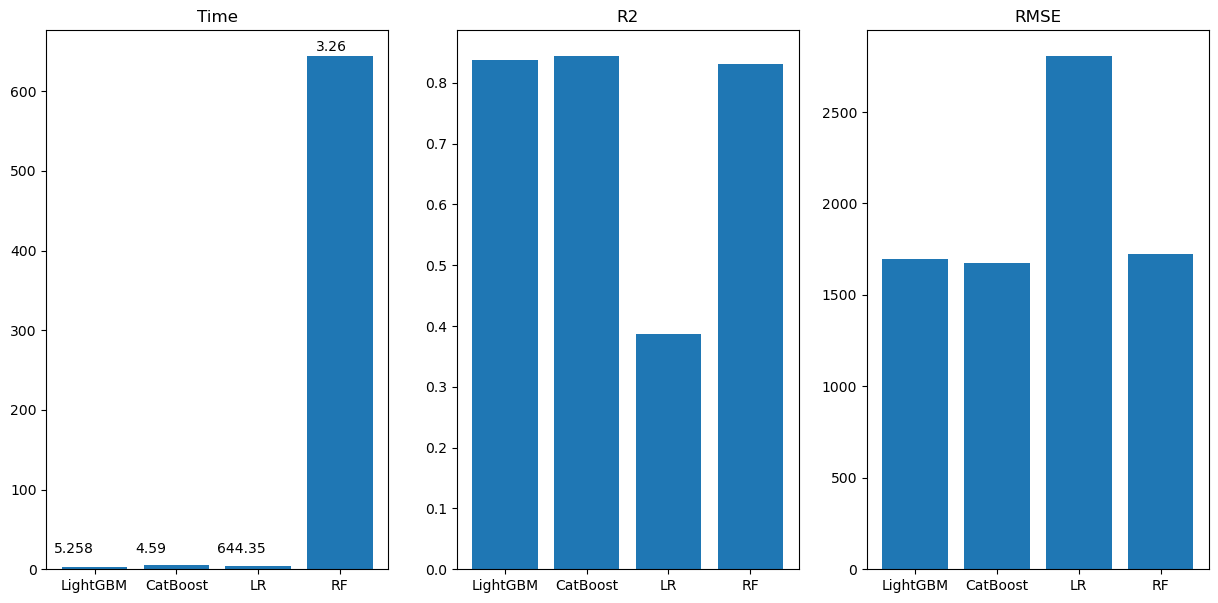

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
ax1.bar(models, time)
ax2.bar(models, r2)
ax3.bar(models, rmse)
ax1.set_title('Time')
ax2.set_title('R2')
ax3.set_title('RMSE')
ax1.text(2.7, 650, time_rf)
ax1.text(-0.5, 20, time_cat)
ax1.text(0.5, 20, time_lr)
ax1.text(1.5, 20, time_lgb);

Анализ показал следующие достоинства и недостатки моделей:
- технология LightGBM градиентного бустинга
    - быстрая скорость работы
    - хорошие метрики качества модели
    - данные необходимо готовить вручную (кодирование, масштабирование)
- технология CatBoost градиентного бустинга
    - быстрая скорость работы
    - лучшие метрики качества модели
    - простота
    - данные можно "скармливать" модели в "сыром виде", кодирование категориальных признаков и масштабирование выполняется моделью
- Линейная регрессия
    - быстрая скорость работы
    - простота
    - неудовлетворительные метрики качества
- Случайные лес
    - хорошие метрики качества
    - очень долгое время затрачивается на подбор модели
    - кодирование и масштабирование признаков в ручном режиме